### Exploration notebook 1 - clustering project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from wrangle_zillow import acquire_zillow
from wrangle_zillow import missing_col_values
from wrangle_zillow import missing_row_values
from wrangle_zillow import single_unit_properties
from wrangle_zillow import data_prep
from wrangle_zillow import split_data
from wrangle_zillow import remove_outliers
from wrangle_zillow import split_by_region

In [2]:
df = acquire_zillow()
df.head()

Reading from csv file...


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
df.shape

(77381, 68)

In [4]:
df = single_unit_properties(df)
remove_cols = ['buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'heatingorsystemdesc']
df = data_prep(df, cols_to_remove=remove_cols, prop_required_column=.5, prop_required_row=.75)


In [5]:
df.shape

(50973, 30)

In [6]:
train, validate, test = split_data(df)
train.shape, validate.shape, test.shape

((28544, 30), (12234, 30), (10195, 30))

In [7]:
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
train = remove_outliers(train, 1.5, out_columns)

In [8]:
train.shape

(26097, 30)

In [9]:
scale_cols = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']]
scaler = MinMaxScaler()
scaler.fit(scale_cols)
scaled_df = scaler.transform(scale_cols)
scaled_cols_df = pd.DataFrame(scaled_df, columns=scale_cols.columns, index=scale_cols.index)

In [10]:
scaled_cols_df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude
57956,0.666667,0.666667,0.740807,0.435923,0.804810
73971,0.666667,0.333333,0.872479,0.575069,0.652562
8195,0.333333,0.333333,0.443357,0.202511,0.816555
7355,0.166667,0.333333,0.303084,0.157001,0.924487
58226,0.666667,0.333333,0.471530,0.308313,0.695515


-----

In [11]:
train.columns

Index(['id', 'parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc'],
      dtype='object')

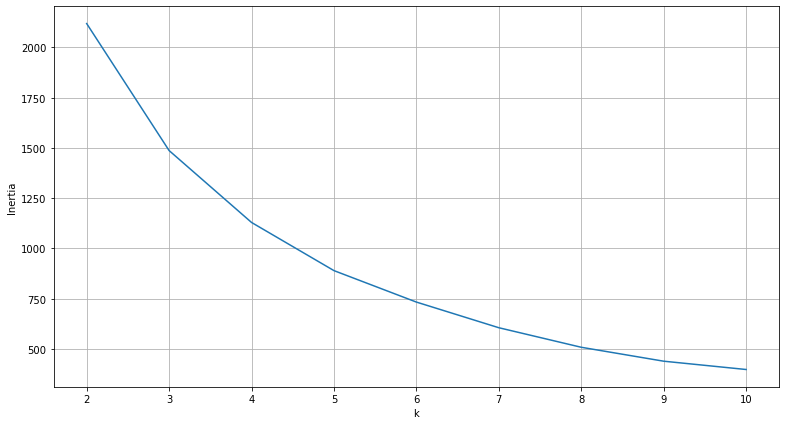

In [12]:
cols = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']
x = scaled_cols_df[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [13]:
x = scaled_cols_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)
train['cluster'] = kmeans.predict(x)

In [14]:
train.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc,cluster
57956,2335449,12844928,3.0,4.0,3.0,2650.0,2650.0,6037.0,3.0,33982542.0,...,413700.0,793000.0,2016.0,379300.0,9646.34,6.037409e+13,0.026122,2017-05-26,Single Family Residential,1
73971,244642,12075460,3.0,3.0,3.0,3094.0,3094.0,6037.0,3.0,34187250.0,...,133565.0,231922.0,2016.0,98357.0,3221.28,6.037461e+13,-0.030712,2017-05-31,Single Family Residential,1
8195,877004,14282224,2.0,3.0,2.0,1647.0,1647.0,6059.0,2.0,33639152.0,...,79671.0,1092488.0,2016.0,1012817.0,12046.64,6.059063e+13,-0.013707,2017-08-07,Single Family Residential,2
7355,2249559,14393950,1.5,3.0,1.5,1174.0,1174.0,6059.0,1.0,33572200.0,...,93580.0,366000.0,2016.0,272420.0,3744.58,6.059042e+13,0.028213,2017-05-24,Single Family Residential,2
58226,1156183,12514614,3.0,3.0,3.0,1742.0,1742.0,6037.0,3.0,33794806.0,...,164991.0,525213.0,2016.0,360222.0,6283.46,6.037574e+13,-0.002124,2017-06-22,Single Family Residential,2


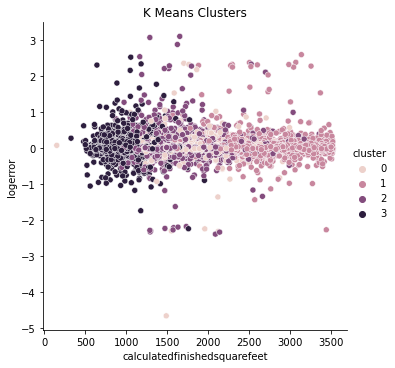

In [15]:
sns.relplot(data=train, y='logerror', x='calculatedfinishedsquarefeet', hue='cluster')
plt.title('K Means Clusters')
plt.show()

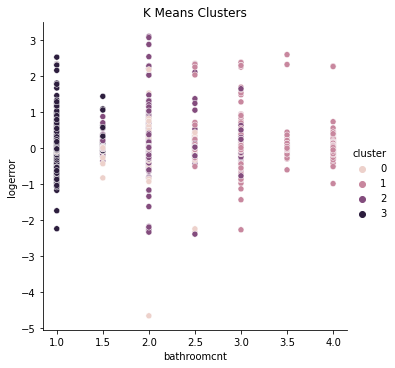

In [16]:
sns.relplot(data=train, y='logerror', x='bathroomcnt', hue='cluster')
plt.title('K Means Clusters')
plt.show()

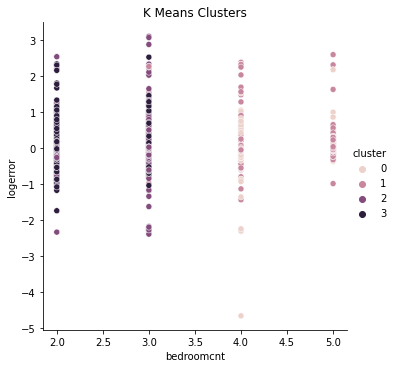

In [17]:
sns.relplot(data=train, y='logerror', x='bedroomcnt', hue='cluster')
plt.title('K Means Clusters')
plt.show()

In [18]:
train.logerror.mean()

0.014703848264029875

In [11]:
x = scaled_cols_df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(x)
train['cluster'] = kmeans.predict(x)

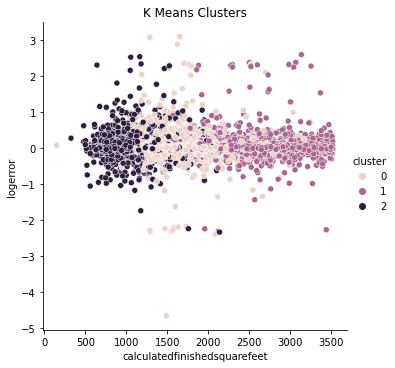

In [12]:
sns.relplot(data=train, y='logerror', x='calculatedfinishedsquarefeet', hue='cluster')
plt.title('K Means Clusters')
plt.show()

In [13]:
clust_1 = train[train['cluster']== 0]
clust_1.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc,cluster
8195,877004,14282224,2.0,3.0,2.0,1647.0,1647.0,6059.0,2.0,33639152.0,...,79671.0,1092488.0,2016.0,1012817.0,12046.64,6.059063e+13,-0.013707,2017-08-07,Single Family Residential,0
58226,1156183,12514614,3.0,3.0,3.0,1742.0,1742.0,6037.0,3.0,33794806.0,...,164991.0,525213.0,2016.0,360222.0,6283.46,6.037574e+13,-0.002124,2017-06-22,Single Family Residential,0
68271,2836157,11152589,2.0,3.0,2.0,1392.0,1392.0,6037.0,2.0,34399593.0,...,147789.0,367028.0,2016.0,219239.0,4897.46,6.037920e+13,-0.033511,2017-01-20,Single Family Residential,0
41172,2663150,12752072,2.0,4.0,2.0,1275.0,1275.0,6037.0,2.0,33900807.0,...,121777.0,272508.0,2016.0,150731.0,3564.41,6.037504e+13,-0.008093,2017-02-23,Single Family Residential,0
32773,853891,11437141,2.0,3.0,2.0,1464.0,1464.0,6037.0,2.0,33893226.0,...,43773.0,74192.0,2016.0,30419.0,1386.91,6.037604e+13,0.010746,2017-05-12,Single Family Residential,0


In [20]:
clust_1.logerror.mean(), clust_1.logerror.max(), clust_1.logerror.min()

(0.013112073244718955, 3.1009133560000004, -4.65542037764)

In [21]:
clust_2 = train[train['cluster']== 1]
clust_2.logerror.mean(), clust_2.logerror.max(), clust_2.logerror.min()

(0.019975892484736843, 2.59421347208, -2.31147282618)

In [19]:
clust_3 = train[train['cluster']== 2]
clust_3.logerror.mean(), clust_3.logerror.max(), clust_3.logerror.min()

(0.01239709263835304, 2.53689634558, -2.33172653205)

In [20]:
#log error by cluster?

---

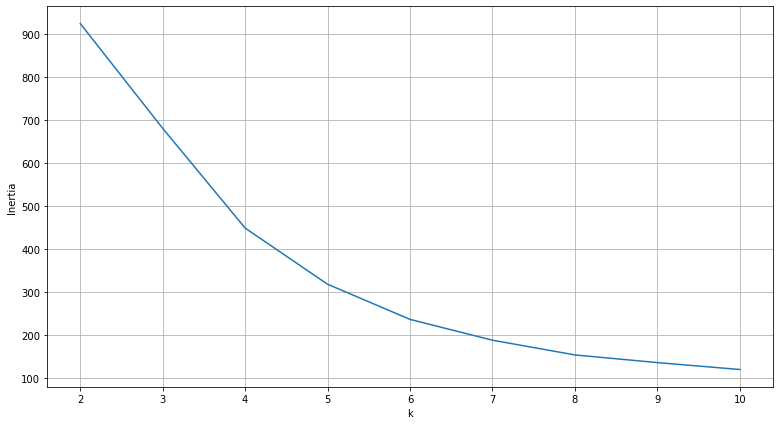

In [11]:
cols = ['latitude', 'longitude']
x = scaled_cols_df[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [11]:
x = scaled_cols_df[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(x)
train['cluster'] = kmeans.predict(x)

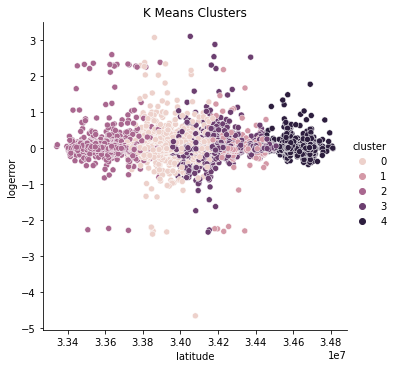

In [12]:
sns.relplot(data=train, y='logerror', x='latitude', hue='cluster')
plt.title('K Means Clusters')
plt.show()

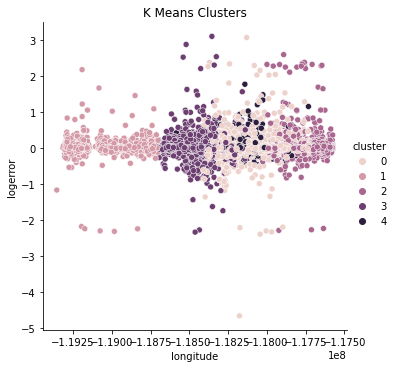

In [13]:
sns.relplot(data=train, y='logerror', x='longitude', hue='cluster')
plt.title('K Means Clusters')
plt.show()

---

In [11]:
x = scaled_cols_df[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)
train['cluster'] = kmeans.predict(x)

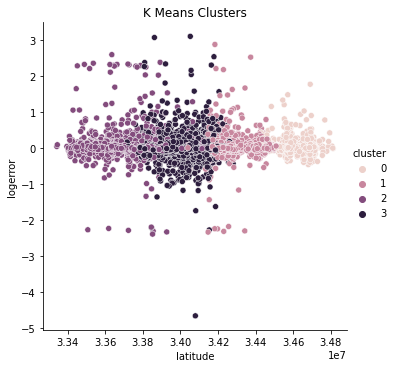

In [12]:
sns.relplot(data=train, y='logerror', x='latitude', hue='cluster')
plt.title('K Means Clusters')
plt.show()

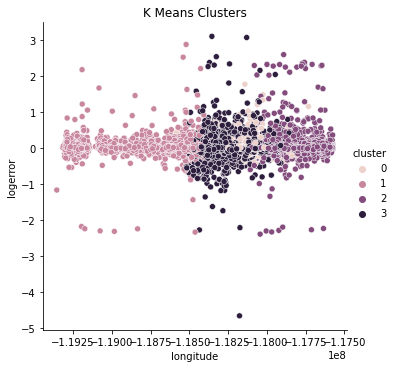

In [13]:
sns.relplot(data=train, y='logerror', x='longitude', hue='cluster')
plt.title('K Means Clusters')
plt.show()

In [15]:
## mean log error by lat/long clusters
log_clust_1 = train[train['cluster']== 0]
log_clust_1.logerror.mean(), log_clust_1.logerror.min(), log_clust_1.logerror.max()

(0.015382024998959147, -0.457327551869, 1.7725639091599998)

In [16]:
log_clust_2 = train[train['cluster']== 1]
log_clust_2.logerror.mean(), log_clust_2.logerror.min(), log_clust_2.logerror.max()

(0.01542552399737953, -2.33172653205, 2.87638586159)

In [17]:
log_clust_3 = train[train['cluster']== 2]
log_clust_3.logerror.mean(), log_clust_3.logerror.min(), log_clust_3.logerror.max()

(0.02143739426008542, -2.38780021423, 2.59421347208)

In [18]:
log_clust_4 = train[train['cluster']== 3]
log_clust_4.logerror.mean(), log_clust_4.logerror.min(), log_clust_4.logerror.max()

(0.009458781626470033, -4.65542037764, 3.1009133560000004)

---

In [9]:
df1, df2, df3 = split_by_region(train)

In [10]:
df1.fips.value_counts()

6037.0    16975
Name: fips, dtype: int64

In [13]:
train.longitude.value_counts()

-117817000.0    4
-117830000.0    4
-117847000.0    4
-117874000.0    3
-117692228.0    3
               ..
-118442865.0    1
-118020936.0    1
-118129364.0    1
-118237972.0    1
-117593269.0    1
Name: longitude, Length: 25700, dtype: int64

fips code 6037.0 = los angeles county 
    - major beach = santa monica beach - 34.012355 / -118.498665

fips code 6059.0 = Orange county
    - major beach = huntington beach - 33.640954 / -117.978893
    
fips code 6111.0 = ventura county
    - major beach = san buenaventura beach - 34.267111 / -119.278788

In [11]:
df1['dist_lat'] = df1.latitude - 34012355
df1['dist_long'] = df1.longitude - (-118498665)
df1.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc,dist_lat,dist_long
57956,2335449,12844928,3.0,4.0,3.0,2650.0,2650.0,6037.0,3.0,33982542.0,...,793000.0,2016.0,379300.0,9646.34,6.037409e+13,0.026122,2017-05-26,Single Family Residential,-29813.0,577489.0
73971,244642,12075460,3.0,3.0,3.0,3094.0,3094.0,6037.0,3.0,34187250.0,...,231922.0,2016.0,98357.0,3221.28,6.037461e+13,-0.030712,2017-05-31,Single Family Residential,174895.0,306240.0
58226,1156183,12514614,3.0,3.0,3.0,1742.0,1742.0,6037.0,3.0,33794806.0,...,525213.0,2016.0,360222.0,6283.46,6.037574e+13,-0.002124,2017-06-22,Single Family Residential,-217549.0,382767.0
1290,689786,11436530,1.0,3.0,1.0,995.0,995.0,6037.0,1.0,33899945.0,...,330564.0,2016.0,215636.0,4119.63,6.037604e+13,-0.035783,2017-01-06,Single Family Residential,-112410.0,158960.0
68271,2836157,11152589,2.0,3.0,2.0,1392.0,1392.0,6037.0,2.0,34399593.0,...,367028.0,2016.0,219239.0,4897.46,6.037920e+13,-0.033511,2017-01-20,Single Family Residential,387238.0,33469.0


In [12]:
scale_cols = df1[['calculatedfinishedsquarefeet', 'dist_lat', 'dist_long']]
scaler = MinMaxScaler()
scaler.fit(scale_cols)
scaled_df = scaler.transform(scale_cols)
scaled_cols_df1 = pd.DataFrame(scaled_df, columns=scale_cols.columns, index=scale_cols.index)

In [13]:
scaled_cols_df1

,calculatedfinishedsquarefeet,dist_lat,dist_long
57956,0.740807,0.435923,0.815963
73971,0.872479,0.575069,0.588702
58226,0.471530,0.308313,0.652819
1290,0.250000,0.379779,0.465306
68271,0.367734,0.719405,0.360166
...,...,...,...
27862,0.523428,0.914744,0.606669
62776,0.346382,0.318617,0.586301
38482,0.516311,0.525517,0.969094
50649,0.397687,0.601878,0.244394


In [20]:
x = scaled_cols_df1[['calculatedfinishedsquarefeet', 'dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)
df1['cluster'] = kmeans.predict(x)

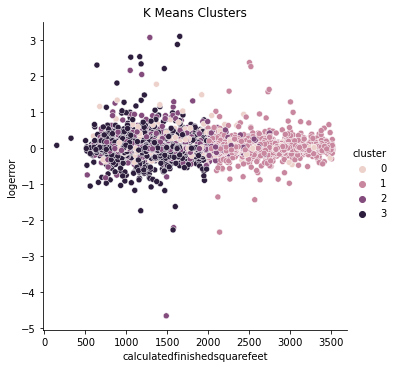

In [21]:
sns.relplot(data=df1, y='logerror', x='calculatedfinishedsquarefeet', hue='cluster')
plt.title('K Means Clusters')
plt.show()

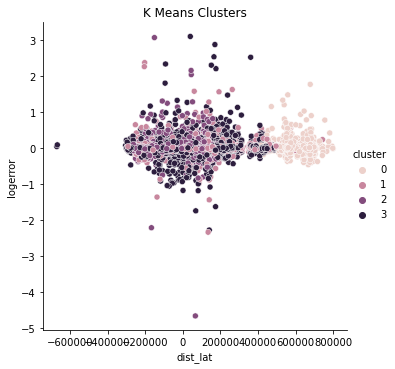

In [23]:
sns.relplot(data=df1, y='logerror', x='dist_lat', hue='cluster')
plt.title('K Means Clusters')
plt.show()

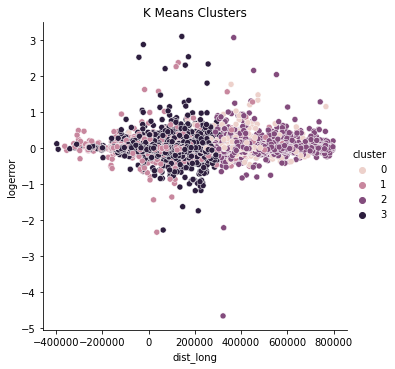

In [24]:
sns.relplot(data=df1, y='logerror', x='dist_long', hue='cluster')
plt.title('K Means Clusters')
plt.show()

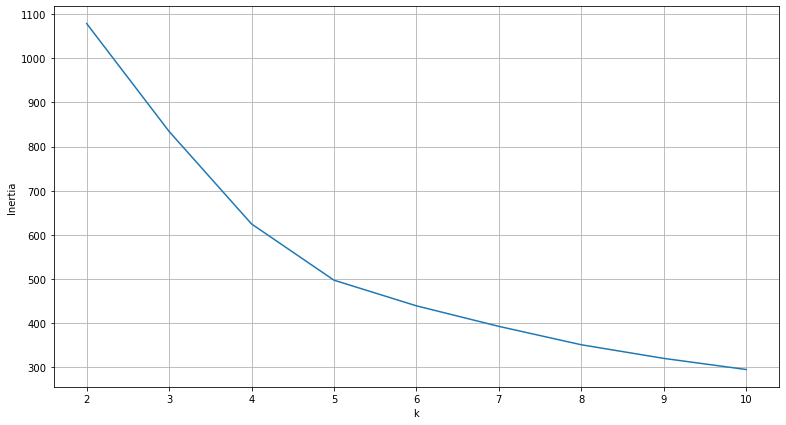

In [22]:
cols = ['calculatedfinishedsquarefeet', 'dist_lat', 'dist_long']
x = scaled_cols_df1[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

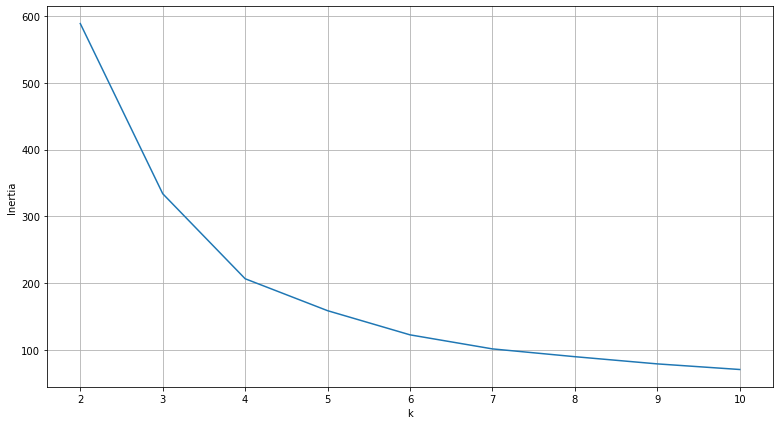

In [14]:
cols = ['dist_lat', 'dist_long']
x = scaled_cols_df1[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [15]:
x = scaled_cols_df1[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)
df1['cluster'] = kmeans.predict(x)

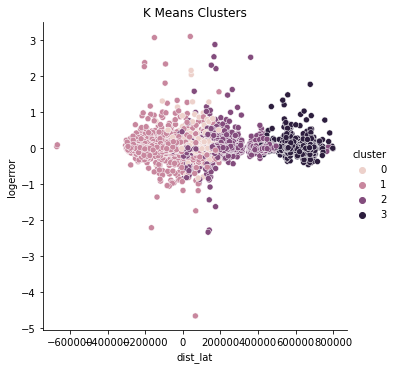

In [16]:
sns.relplot(data=df1, y='logerror', x='dist_lat', hue='cluster')
plt.title('K Means Clusters')
plt.show()

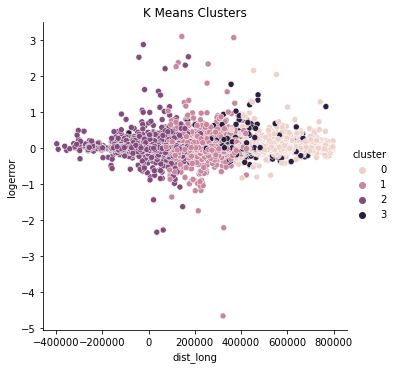

In [17]:
sns.relplot(data=df1, y='logerror', x='dist_long', hue='cluster')
plt.title('K Means Clusters')
plt.show()

In [18]:
df1.logerror.mean()

0.012294842036901862

In [19]:
log_clust_1 = df1[df1['cluster']== 0]
log_clust_1.logerror.mean(), log_clust_1.logerror.min(), log_clust_1.logerror.max()

(0.0190353984016624, -0.8262354438609999, 2.15726554211)

In [20]:
log_clust_2 = df1[df1['cluster']== 1]
log_clust_2.logerror.mean(), log_clust_2.logerror.min(), log_clust_2.logerror.max()

(0.008496755690316394, -4.65542037764, 3.1009133560000004)

In [21]:
log_clust_3 = df1[df1['cluster']== 2]
log_clust_3.logerror.mean(), log_clust_3.logerror.min(), log_clust_3.logerror.max()

(0.011368134676223942, -2.33172653205, 2.87638586159)

In [22]:
log_clust_4 = df1[df1['cluster']== 3]
log_clust_4.logerror.mean(), log_clust_4.logerror.min(), log_clust_4.logerror.max()

(0.015169539650773946, -0.457327551869, 1.7725639091599998)

In [21]:
df2.fips.value_counts()

6059.0    6803
Name: fips, dtype: int64

In [22]:
df2['dist_lat'] = df2.latitude - 33640954
df2['dist_long'] = df2.longitude - (-117978893)
df2.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc,dist_lat,dist_long,cluster
8195,877004,14282224,2.0,3.0,2.0,1647.0,1647.0,6059.0,2.0,33639152.0,...,2016.0,1012817.0,12046.64,6.059063e+13,-0.013707,2017-08-07,Single Family Residential,-1802.0,78644.0,1
7355,2249559,14393950,1.5,3.0,1.5,1174.0,1174.0,6059.0,1.0,33572200.0,...,2016.0,272420.0,3744.58,6.059042e+13,0.028213,2017-05-24,Single Family Residential,-68754.0,270938.0,2
69846,2354007,14480963,3.0,4.0,3.0,3343.0,3343.0,6059.0,3.0,33617749.0,...,2016.0,120398.0,6315.54,6.059032e+13,0.108356,2017-07-13,Single Family Residential,-23205.0,402115.0,2
4787,1384644,14403879,3.5,3.0,3.5,3494.0,3494.0,6059.0,3.0,33527824.0,...,2016.0,2174000.0,32291.48,6.059063e+13,0.051695,2017-04-27,Single Family Residential,-113130.0,214774.0,2
64043,2620495,14003836,1.0,2.0,1.0,871.0,871.0,6059.0,1.0,33789358.0,...,2016.0,119674.0,2113.80,6.059088e+13,0.064396,2017-03-08,Single Family Residential,148404.0,-18929.0,0


In [23]:
scale_cols = df2[['dist_lat', 'dist_long']]
scaler = MinMaxScaler()
scaler.fit(scale_cols)
scaled_df = scaler.transform(scale_cols)
scaled_cols_df2 = pd.DataFrame(scaled_df, columns=scale_cols.columns, index=scale_cols.index)

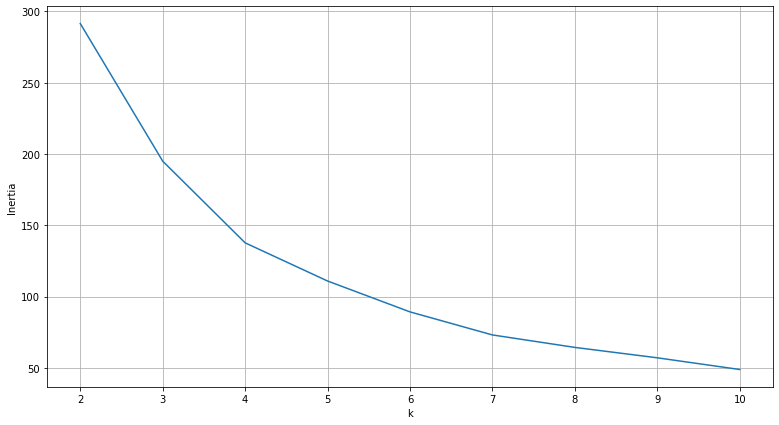

In [24]:
cols = ['dist_lat', 'dist_long']
x = scaled_cols_df2[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [25]:
x = scaled_cols_df2[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)
df2['cluster'] = kmeans.predict(x)

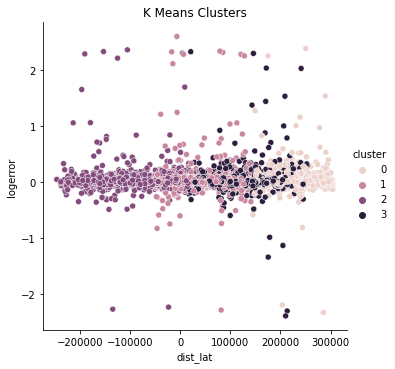

In [26]:
sns.relplot(data=df2, y='logerror', x='dist_lat', hue='cluster')
plt.title('K Means Clusters')
plt.show()

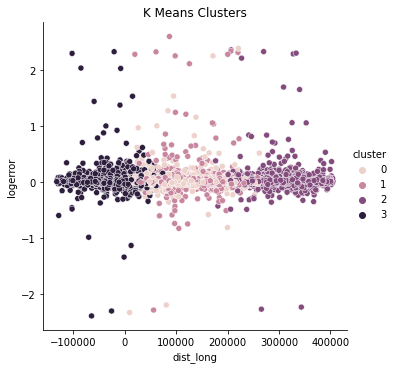

In [27]:
sns.relplot(data=df2, y='logerror', x='dist_long', hue='cluster')
plt.title('K Means Clusters')
plt.show()

In [10]:
df3.fips.value_counts()

6111.0    2319
Name: fips, dtype: int64

In [11]:
df3['dist_lat'] = df3.latitude - 34267111
df3['dist_long'] = df3.longitude - (-119278788)
df3.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc,dist_lat,dist_long
17871,1418044,17278540,2.0,3.0,2.0,1688.0,1688.0,6111.0,2.0,34222291.0,...,70421.0,2016.0,18614.0,772.56,6.111006e+13,0.041310,2017-01-31,Single Family Residential,-44820.0,416755.0
51968,2370498,17080633,2.0,2.0,2.0,1291.0,1291.0,6111.0,2.0,34266662.0,...,505000.0,2016.0,328000.0,5305.42,6.111003e+13,-0.140122,2017-08-18,Single Family Residential,-449.0,24113.0
53854,2014375,17242210,2.5,4.0,2.5,1725.0,1725.0,6111.0,2.0,34275963.0,...,438388.0,2016.0,285008.0,5076.98,6.111008e+13,-0.005113,2017-07-10,Single Family Residential,8852.0,487068.0
12435,1596739,17219147,2.0,2.0,2.0,1128.0,1128.0,6111.0,2.0,34209335.0,...,80688.0,2016.0,18588.0,839.50,6.111008e+13,-0.047332,2017-06-30,Cluster Home,-57776.0,437375.0
19330,2014382,17243619,2.0,3.0,2.0,1103.0,1103.0,6111.0,2.0,34270239.0,...,57400.0,2016.0,14461.0,1002.16,6.111008e+13,0.177023,2017-06-29,Single Family Residential,3128.0,513304.0


In [12]:
scale_cols = df3[['dist_lat', 'dist_long']]
scaler = MinMaxScaler()
scaler.fit(scale_cols)
scaled_df = scaler.transform(scale_cols)
scaled_cols_df3 = pd.DataFrame(scaled_df, columns=scale_cols.columns, index=scale_cols.index)

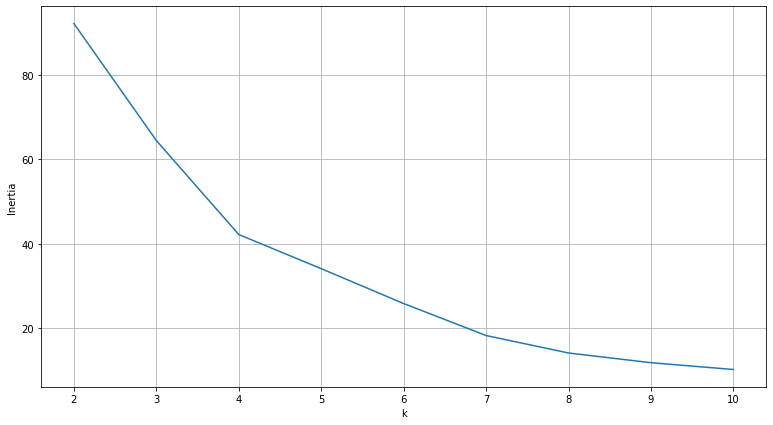

In [13]:
cols = ['dist_lat', 'dist_long']
x = scaled_cols_df3[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [14]:
x = scaled_cols_df3[['dist_lat', 'dist_long']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(x)
df3['cluster'] = kmeans.predict(x)

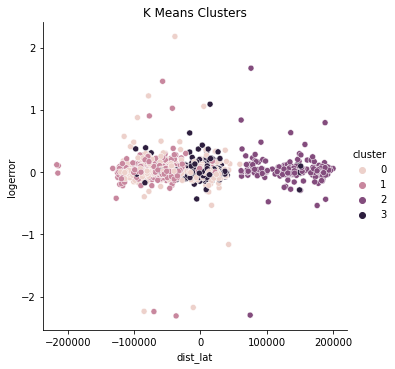

In [15]:
sns.relplot(data=df3, y='logerror', x='dist_lat', hue='cluster')
plt.title('K Means Clusters')
plt.show()

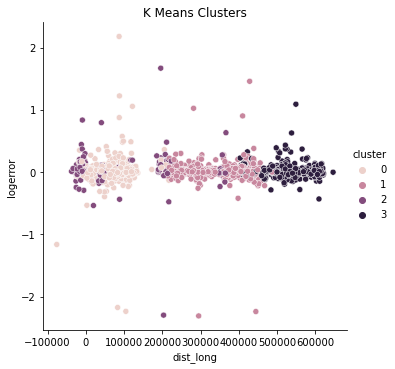

In [16]:
sns.relplot(data=df3, y='logerror', x='dist_long', hue='cluster')
plt.title('K Means Clusters')
plt.show()

In [17]:
log_clust_1 = df3[df3['cluster']== 0]
log_clust_1.logerror.mean(), log_clust_1.logerror.min(), log_clust_1.logerror.max()

(0.011460552854573664, -2.23811211964, 2.17736277445)

In [18]:
log_clust_2 = df3[df3['cluster']== 1]
log_clust_2.logerror.mean(), log_clust_2.logerror.min(), log_clust_2.logerror.max()

(0.0064735847408253725, -2.31147282618, 1.45741895665)

In [19]:
log_clust_3 = df3[df3['cluster']== 2]
log_clust_3.logerror.mean(), log_clust_3.logerror.min(), log_clust_3.logerror.max()

(0.026825471129708556, -2.29862688752, 1.6680783391799998)

In [20]:
log_clust_4 = df3[df3['cluster']== 3]
log_clust_4.logerror.mean(), log_clust_4.logerror.min(), log_clust_4.logerror.max()

(0.013534173816603122, -0.432849961507, 1.08940584401)